In [82]:
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [83]:
k,gamma,D = 1.0,1.0,1.0
delta_t=0.01
ampl = np.sqrt(2*D*delta_t)
N=2000

In [84]:
# random force
w=np.random.normal(0,1,N)

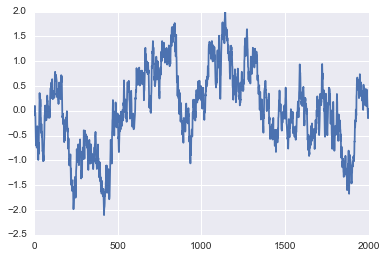

In [85]:
# differential equation x_i = x_(i-1) - k/gamma*x_(i-1) + sqrt(2*D*delta_t)*w_i
from itertools import accumulate
def next_point(x,y):
    return x - k/gamma*x*delta_t + ampl*y

x = np.fromiter(accumulate(w, next_point),np.float)
plt.plot(x)

In [86]:
print("std: ",x.std(),"mean: ",x.mean())

std:  0.7766783964 mean:  0.0436866712247


In [87]:
# see http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.fftconvolve.html
from scipy import signal
autocorr = signal.fftconvolve(x, x[::-1], mode='full')

3999


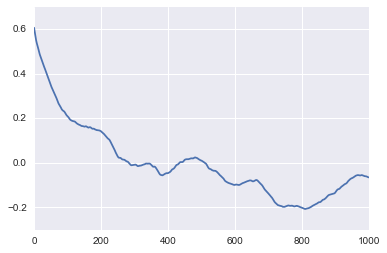

In [88]:
n=len(autocorr)
print(n)
autocorr=autocorr[int((n-1)/2):]*2.0/(n+1)
plt.plot(autocorr[:1000])

In [89]:
import lmfit as lm

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.529
    reduced chi-square = 0.001
    Akaike info crit   = -3419.766
    Bayesian info crit = -3411.337
[[Variables]]
    decay:       103.641809 +/- 1.618265 (1.56%) (init= 114.8983)
    amplitude:   0.57890659 +/- 0.006348 (1.10%) (init= 0.4558211)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.705 



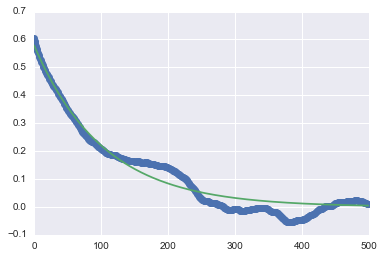

In [90]:
from lmfit.models import ExponentialModel

mod = ExponentialModel()
y = autocorr[:500]
t = np.arange(500)

pars = mod.guess(y, x=t)
out  = mod.fit(y, pars, x=t)
print(out.fit_report(min_correl=0.25))

plt.plot(t,y,"o")
plt.plot(t,out.best_fit)

In [91]:
# now lets model this data using pymc
import pymc as pm

In [92]:
# define the model/function to be fitted.
def model(x): 
    t = pm.Uniform('t', 0.1, 20, value=2.0)
    A = pm.Uniform('A', 0.1, 10, value=1.0)
    
    @pm.deterministic(plot=False)
    def S(t=t):
        return 1-np.exp(-4*delta_t/t)
    
    @pm.deterministic(plot=False)
    def s(t=t):
        return np.exp(-2*delta_t/t)
        
    path = np.empty(N, dtype=object)
    
    path[0]=pm.Normal('path_0',mu=0, tau=1/A, value=x[0], observed=True)
    for i in range(1,N):
        path[i] = pm.Normal('path_%i' % i,
                            mu=path[i-1]*s,
                            tau=1/A/S,
                            value=x[i],
                            observed=True)
    return locals()

mcmc = pm.MCMC( model(x) )
mcmc.sample( 20000, 2000, 10 )

 [-----------------100%-----------------] 20001 of 20000 complete in 2271.2 sec

Plotting t
Plotting A


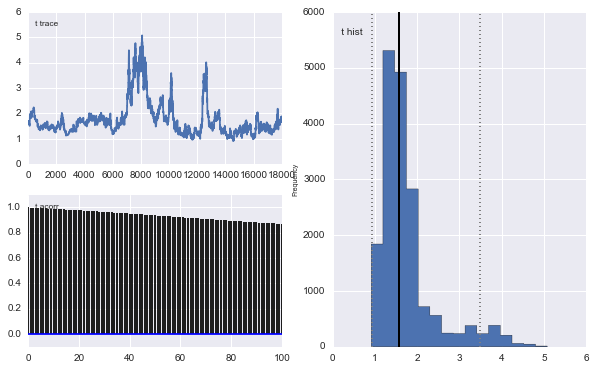

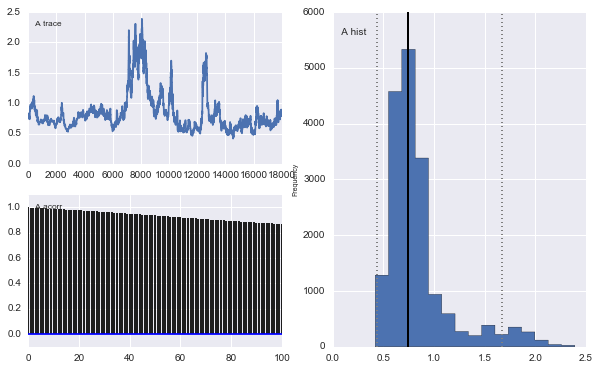

In [93]:
pm.Matplot.plot(mcmc)

In [94]:
mcmc.summary()


t:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.755            0.679            0.065            [ 0.926  3.482]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.058            1.354           1.56           1.843         3.895
	

A:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.843            0.324            0.031            [ 0.442  1.668]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.511            0.65            0.748          0.889         1.863
	

s:
 
	Mean             SD               MC Error        95% HPD interval
	---------------------------------